In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from bilby.gw.detector import PowerSpectralDensity
from scipy.interpolate import interp1d
from typing import Tuple
import yaml
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

np.random.seed(1)
from dingo.gw.domains import build_domain, MultibandedFrequencyDomain, UniformFrequencyDomain
from dingo.gw.domains.multibanded_frequency_domain import get_band_nodes_for_adaptive_decimation
from dingo.gw.prior import build_prior_with_defaults
from dingo.gw.waveform_generator import WaveformGenerator, NewInterfaceWaveformGenerator
from dingo.gw.dataset.generate_dataset import generate_parameters_and_polarizations
import pyseobnr

# Multibanding: How to define the bands for precessing waveforms?
(based on a notebook from Max, see [this commit](https://github.com/dingo-gw/dingo-development/commit/38f9b86027848fe709cf053f68c979ea61b1b4e9))

In the DINGO-BNS paper, the bands for multibanding are defined based on the periods of the waveform, implemented via zero-crossings.
The bands were chosen such that each period is covered by at least 32 bins.

However, this approach does not work for precessing waveforms like `IMRPhenomXPHM` or `SEOBNRv5PHM` since the waveform might not cross zero in every period. This notebook explores a different implementation for finding the bands based on the difference of the data in the multibanded frequency domain (mfd) $\overline{d_j^w}$ and the data in the uniform frequency domain (ufd) evaluated at the mfd frequency values $\overline{f_i}$.

In the Appendix of the DINGO-BNS paper ([arXiv:2407.09602v2](https://arxiv.org/abs/2407.09602v2)), multibanding is explained in detail.
The whole argument for multibanding is based on the Whittle likelihood (in mfd) which reads

$$
\log p(d|\theta) \approx -\frac{1}{2}\sum_j \frac{|\overline{d_j^w} - \overline{h_j^w}(\theta)|^2}{\sigma_{i(j)}^2\cdot \overline{S_j}}
$$

where $j$ indexes the mfd bins, $\overline{S_j}$ denotes the averaged PSD over the decimation window associated with mfd bin j, and $\sigma_{i(j)} = \sqrt{\frac{w}{4\Delta f_i}}$ is computed based on the frequency resolution  in bin $i$ of the decimation window associated with $j$, and the window factor $w$.

For the BNS paper, Max investigated in [`binary_neutron_stars/prototyping/psd_decimation.ipynb`](https://github.com/dingo-gw/dingo-development/blob/bns_add_dingo_pipe_max/binary_neutron_stars/prototyping/psd_decimation.ipynb) that the data should be whitened in the base domain and decimated afterward. This notebook also contains more details about decimating the ASD.

In [2]:
# Load settings file
settings_file = "settings_wfd.yaml"
try:
    with open(settings_file, "r") as file:
        settings_wfd = yaml.safe_load(file)
except FileNotFoundError:
    print(f"Settings file '{settings_file}' not found. Please ensure it exists in the directory.")
print(settings_wfd)

{'domain': {'type': 'FrequencyDomain', 'f_min': 20.0, 'f_max': 2048.0, 'delta_f': 0.0625}, 'waveform_generator': {'approximant': 'SEOBNRv5PHM', 'f_ref': 20.0, 'f_start': 13.33, 'new_interface': True, 'spin_conversion_phase': 0.0}, 'intrinsic_prior': {'mass_1': 'bilby.core.prior.Constraint(minimum=10.0, maximum=120.0)', 'mass_2': 'bilby.core.prior.Constraint(minimum=10.0, maximum=120.0)', 'chirp_mass': 'bilby.gw.prior.UniformInComponentsChirpMass(minimum=10.0, maximum=16.0)', 'mass_ratio': 'bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1.0)', 'phase': 'default', 'a_1': 'bilby.core.prior.Uniform(minimum=0.0, maximum=0.99)', 'a_2': 'bilby.core.prior.Uniform(minimum=0.0, maximum=0.99)', 'tilt_1': 'default', 'tilt_2': 'default', 'phi_12': 'default', 'phi_jl': 'default', 'theta_jn': 'default', 'luminosity_distance': 100.0, 'geocent_time': 0.0}, 'num_samples': 10000000, 'compression': {'svd': {'size': 300, 'num_training_samples': 100000, 'num_validation_samples': 20000}, 

In [3]:
# Build domain
uniform_frequency_domain_settings = settings_wfd["domain"]
# set window factor for ufd
uniform_frequency_domain_settings["window_factor"] = 4.
ufd = build_domain(uniform_frequency_domain_settings)

# Build prior
intrinsic_prior_settings = settings_wfd["intrinsic_prior"]
prior = build_prior_with_defaults(intrinsic_prior_settings)

# Generate waveforms
To obtain a reasonable estimate for the error introduced by multibanding, we generate a set of waveforms in the ufd.

We will decimate these waveforms to the mfd with decimation factors [1,2,4,8,16]. A decimation factor of 1 means that we will keep each frequency bin from ufd, while a factor of 2 means that we will compute the mean of the waveform within a decimation window containing 2 frequency bins of the ufd ($[f_0, f_1] \rightarrow [f_{1/2}]$). If we want to compare the decimated waveform to the waveform in ufd, we need to evaluate the waveform the mfd frequency values (i.e. $f_{1/2}$). While nothing changes for a decimation factor of 1, the frequency values in the mfd are right in the middle of two ufd frequency values for a decimation window of 2 ($f_{1/2} = 0.5 \cdot (f_0 + f_1)$). (For 4, they are right between $f_1$ and $f_2$ for $[f_0, f_1, f_2, f_3]$, etc.)

This means that we need a reference waveform dataset with **twice** the resolution of the base domain.

In [4]:
# Generate waveforms in a domain with twice the resolution of ufd, such that we can later compare the decimated mfd waveforms to the high-resolution waveform as a reference.
wfg_settings = settings_wfd["waveform_generator"]
print(wfg_settings)
num_samples = 1000
num_processes = 1
ufd_twice_res = build_domain({**ufd.domain_dict, **{"delta_f": ufd.domain_dict["delta_f"] / 2}})
assert (ufd_twice_res()[::2] == ufd()).all()
waveform_generator = NewInterfaceWaveformGenerator(domain=ufd_twice_res, **wfg_settings)
parameters, polarizations_twice_res = generate_parameters_and_polarizations(
    waveform_generator, prior, num_samples, num_processes
)
# Down-sample polarization to match standard ufd resolution
polarizations = {k: v[...,::2] for k, v in polarizations_twice_res.items()}
assert polarizations["h_plus"][0].shape == ufd().shape

{'approximant': 'SEOBNRv5PHM', 'f_ref': 20.0, 'f_start': 13.33, 'new_interface': True, 'spin_conversion_phase': 0.0}
Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.
Generating dataset of size 1000


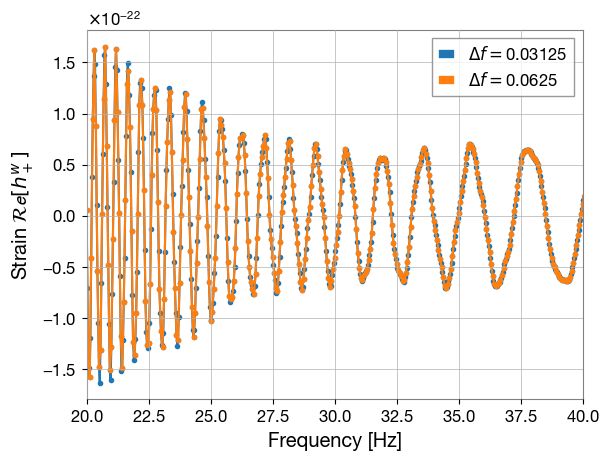

In [5]:
plt.plot(ufd_twice_res.sample_frequencies[ufd_twice_res.frequency_mask], 
         polarizations_twice_res["h_plus"][0].real[ufd_twice_res.frequency_mask], 
         "-o", markersize=3, label=r"$\Delta f=$"+f"{ufd.domain_dict['delta_f'] / 2}"
        )
plt.plot(ufd.sample_frequencies[ufd.frequency_mask], 
         polarizations["h_plus"][0].real[ufd.frequency_mask], 
         "-o", markersize=3, label=r"$\Delta f=$"+f"{ufd.domain_dict['delta_f']}"
        )
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"Strain $\mathcal{Re}[h_+^w]$")
plt.xlim(20, 40)
plt.legend()
plt.show()

# Load ASD
Load design sensitivity curve for LIGO because it is the most conservative estimate for noise: If the noise were larger, the likelihood is inversely affected by it which means that the likelihood would get smaller (in absolute values). As a result, using the design sensitivity PSD is the most conservative estimate for finding the nodes in multi-banding. (With a larger noise PSD, there is less information content in each band, meaning we could in principle make it larger than it is.)

This also motivates why it is save to remove spectral lines which makes the estimation of the bands smoother.

In [6]:
asd_file = "aLIGO_ZERO_DET_high_P_asd.txt"
psd = PowerSpectralDensity(asd_file=asd_file)
asd_interp = interp1d(psd.frequency_array, psd.asd_array, bounds_error=False, fill_value=np.inf)
asd_twice_res = asd_interp(ufd_twice_res.sample_frequencies)
# Remove the bump
asd_twice_res[np.where((ufd_twice_res() > 477) & (ufd_twice_res() < 483))[0]] = asd_twice_res[np.argmin(np.abs(ufd_twice_res() - 477))]
# Down-sample ASD to match standard ufd resolution
asd = asd_twice_res[::2]

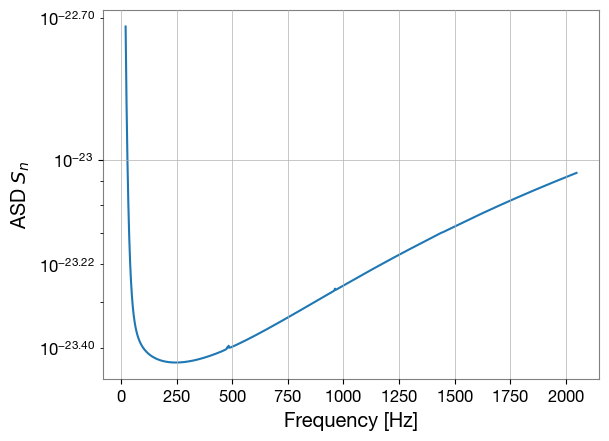

In [7]:
plt.plot(ufd()[ufd.frequency_mask], asd[ufd.frequency_mask])
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"ASD $S_n$")
plt.yscale("log")
plt.show()

# How to determine the bands?
### Previously:
* Calculate period (i.e. zero-crossings) for each ufd bin based on real part of each waveform
* Obtain minimal period for each ufd frequency bin (replace min by first percentile to make it more stable)
* Define maximally allowed decimation as periods / min_bins_per_period=32 ($\rightarrow$ each period is covered by at least 32 mfd frequency bins)

### Now:
* Decimate whitened waveforms based on range of decimation factors (using convolution)
* Calculate the difference between the decimated whitened waveform and the whitened waveform in the ufd
* Define maximally allowed decimation through threshold value for the difference

### How to define the convolution:
1. Convolution with stride=1:
not suitable because this calculates the mean of each pair of neighboring bins (i.e. [1, 2, 3] -> [1.5, 2.5]), thus not reducing the dimensionality of the data by decimation_factor
2. Convolution with stride=decimation_factor:
what we want

Input data: (1000, 32769)


/var/folders/3s/k8hkbxc95rs93_htsl1k_sb00002q4/T/ipykernel_50352/732978128.py:12: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1037.)
  conv = lambda d: torch.nn.functional.conv1d(


Conv with stride=1: (1000, 32769)
Conv with stride=decimation_factor: torch.Size([1000, 4096])


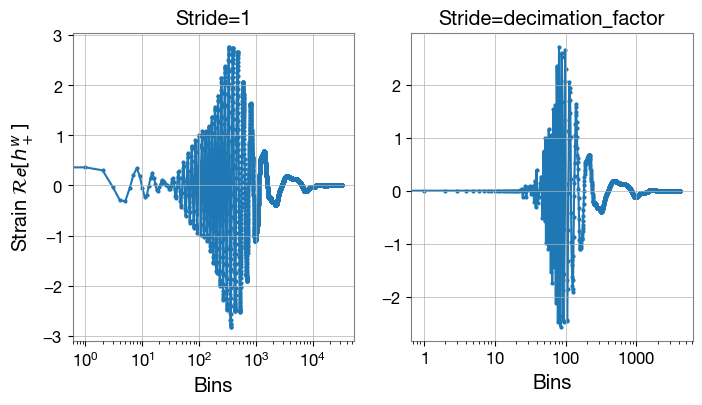

In [8]:
decimation_factor = 8

# Whiten
data = polarizations["h_plus"] / asd / ufd.noise_std
data = data.real
print("Input data:", data.shape)

# Construct convolution kernel
kernel = torch.ones((1, 1, decimation_factor), dtype=torch.float64) / decimation_factor

# Pad with "same", stride=1 -> mean calculated of each pair of neighboring bins -> len not reduced by decimation_factor
conv = lambda d: torch.nn.functional.conv1d(
    torch.tensor(data, dtype=torch.float64)[:, None, :], 
    kernel, 
    padding="same", 
    dilation=1
).squeeze()
data_decimated = np.array(conv(data))
print("Conv with stride=1:", data_decimated.shape)
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(data_decimated[0][ufd.frequency_mask], "-o", markersize=2)
axs[0].set_title("Stride=1")
axs[0].set_ylabel(r"Strain $\mathcal{Re}[h_+^w]$")

# Pad with 0, stride = decimation_factor
conv = lambda d: torch.nn.functional.conv1d(
    torch.tensor(d, dtype=torch.float64)[:, None, :], 
    kernel, 
    padding=0,
    stride=decimation_factor,
).squeeze()
data_decimated = conv(data)
print("Conv with stride=decimation_factor:", data_decimated.shape)
axs[1].plot(data_decimated[0], "-o", markersize=2)
axs[1].set_title("Stride=decimation_factor")
for ax in axs:
    ax.set_xlabel("Bins")
    ax.set_xscale('log')

### How to quantify the deviation introduced by multibanding:
1. **Compare decimated waveform value to all waveform values in the ufd (within the corresponding decimation window)**:
Repeat the mfd data value (= mean over multiple ufd bins) to match the number of bins per decimation window in the ufd and compare. Taking the max of this would result in computing the maximal deviation per mfd bin (=ufd decimation window). 
2. **Compare the mfd waveform value to the true ufd waveform value at the mfd frequency (i.e. evaluate waveform at center of ufd decimation window)**.
This means that we apply a convolution to the frequency values in the ufd to get the mfd frequency values (= mean of frequencies in each decimation window) and evaluate the waveform at these mfd frequency values. Therefore, we are comparing the decimated waveform to the true waveform only at the center of the decimation window. The disadvantage of this approach is that it will not flag cases where the waveform in the left half of the decimation window has opposite sign but same magnitude compared to the right half of the window. In such a case, contributions to the mean with opposite sign and magnitude cancel out, but the decimated waveform aligns with the waveform evaluated at the center of the decimation window.

### Investigate difference of 1. and 2. for one specific signal

In [9]:
# decimation_factors = [1, 2, 4, 8, 16, 32]
decimation_factors = 2 ** np.arange(8)
freq = ufd()

 # Whiten
data = polarizations["h_plus"] / asd / ufd.noise_std
data = data.real
data_2x = polarizations_twice_res["h_plus"] / asd_twice_res / ufd.noise_std  # not ufd_full!
data_2x = data_2x.real
assert freq.shape == data[0].shape

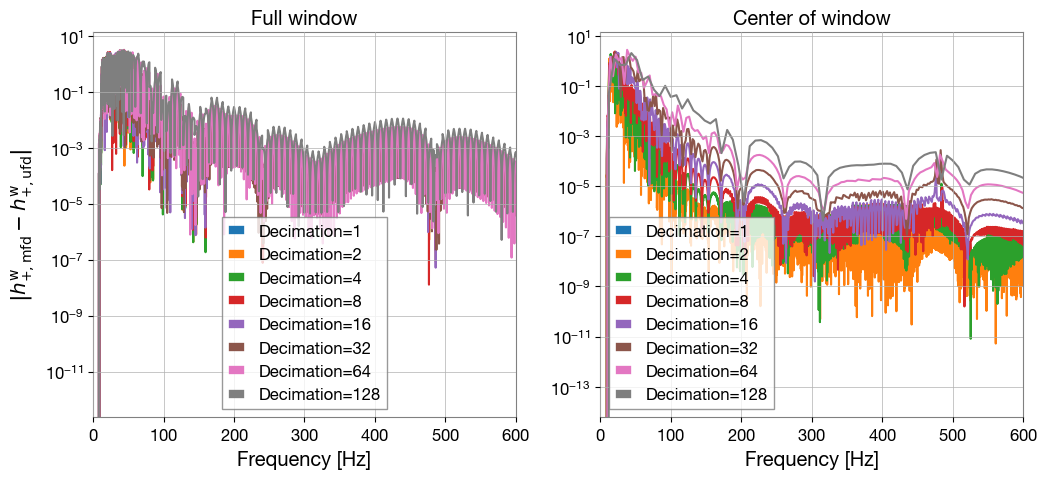

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
    
for decimation_factor in decimation_factors:
    # Construct convolution kernel
    kernel = torch.ones((1, 1, decimation_factor), dtype=torch.float64) / decimation_factor
    conv = lambda d: torch.nn.functional.conv1d(
        torch.tensor(d, dtype=torch.float64)[:, None, :], 
        kernel, 
        padding=0,
        stride=decimation_factor,
    ).squeeze()
    data_decimated = conv(data)

    # Compares the decimated value to all values within the decimation window
    # (most conservative estimate for difference between original and decimated data)
    data_ref = data
    f_ref = freq
    data_new = np.repeat(np.array(data_decimated), decimation_factor, axis=-1)
    n_pad = data_ref.shape[1] - data_new.shape[1]
    data_new = np.pad(data_new, ((0, 0), (0, n_pad)), 'constant', constant_values=0)
    diff = np.abs(data_ref - data_new)
    # Plot
    axs[0].plot(f_ref, diff[0], label=f"Decimation={decimation_factor}")
    
    # Compares the decimated value only to the waveform value at the frequency value in the middle of each band
    f_ref = conv(freq[None, :])
    inds_ref = (f_ref / ufd_twice_res.delta_f).type(torch.int32)
    data_ref = data_2x[:, inds_ref]
    data_new = np.array(data_decimated)
    diff = np.abs(data_ref - data_new)
    # Plot
    axs[1].plot(f_ref, diff[0], label=f"Decimation={decimation_factor}")
    
axs[0].set_title("Full window")
axs[1].set_title("Center of window")
axs[0].set_ylabel(r"$\left|h^\mathrm{w}_\mathrm{+,mfd} - h^\mathrm{w}_\mathrm{+,ufd}\right|$")
for ax in axs:
    ax.set_xlabel("Frequency [Hz]")
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlim(0,600)

## Compare max and 95th percentile for 1. and 2.

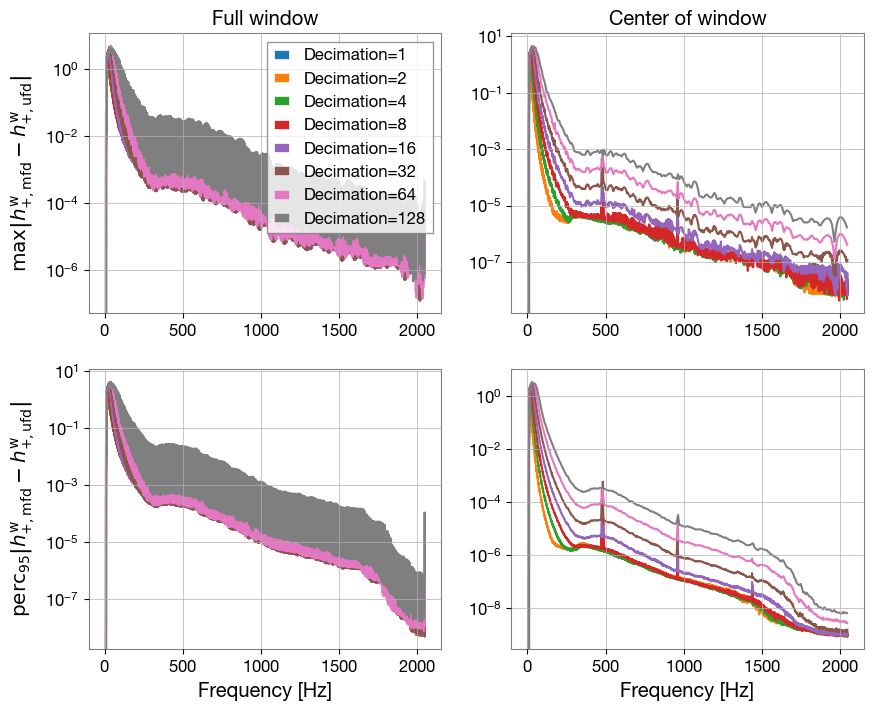

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
    
for decimation_factor in decimation_factors:
    # Construct convolution kernel
    kernel = torch.ones((1, 1, decimation_factor), dtype=torch.float64) / decimation_factor
    conv = lambda d: torch.nn.functional.conv1d(
        torch.tensor(d, dtype=torch.float64)[:, None, :], 
        kernel, 
        padding=0,
        stride=decimation_factor,
    ).squeeze()
    data_decimated = conv(data)

    # Compares the decimated value to all values within the decimation window
    # (most conservative estimate for difference between original and decimated data)
    d_ref = data
    f_ref = freq
    d_new = np.repeat(np.array(data_decimated), decimation_factor, axis=-1)
    n_pad = d_ref.shape[1] - d_new.shape[1]
    d_new = np.pad(d_new, ((0, 0), (0, n_pad)), 'constant', constant_values=0)
    diff = np.abs(d_ref - d_new)
    diff_max = np.max(diff, axis=0)
    diff_perc = np.percentile(diff, 99, axis=0)
    # Plot
    axs[0,0].plot(f_ref, diff_max, label=f"Decimation={decimation_factor}")
    axs[1,0].plot(f_ref, diff_perc, label=f"Decimation={decimation_factor}")
    
    # Compares the decimated value only to the waveform value at the frequency value in the middle of each band
    f_ref = conv(freq[None, :])
    inds_ref = (f_ref / (ufd.delta_f/2)).type(torch.int32)
    d_ref = data_2x[:, inds_ref]
    d_new = np.array(data_decimated)
    diff = np.abs(d_ref - d_new)
    diff_max = np.max(diff, axis=0)
    diff_perc = np.percentile(diff, 95, axis=0)
    # Plot
    axs[0,1].plot(f_ref, diff_max, label=f"Decimation={decimation_factor}")
    axs[1,1].plot(f_ref, diff_perc, label=f"Decimation={decimation_factor}")
    
axs[0,0].set_title("Full window")
axs[0,1].set_title("Center of window")
axs[0,0].set_ylabel(r"$\max \left|h^\mathrm{w}_\mathrm{+,mfd} - h^\mathrm{w}_\mathrm{+,ufd}\right|$")
axs[1,0].set_ylabel(r"$\mathrm{perc}_{95} \left|h^\mathrm{w}_\mathrm{+,mfd} - h^\mathrm{w}_\mathrm{+,ufd}\right|$")
axs[1,0].set_xlabel("Frequency [Hz]")
axs[1,1].set_xlabel("Frequency [Hz]")
axs[0,0].legend()
for ax in axs.flatten():
    ax.set_yscale('log')
    #ax.set_xlim(0,800)

## Compare accumulated difference (max and percentile) for 1. and 2.

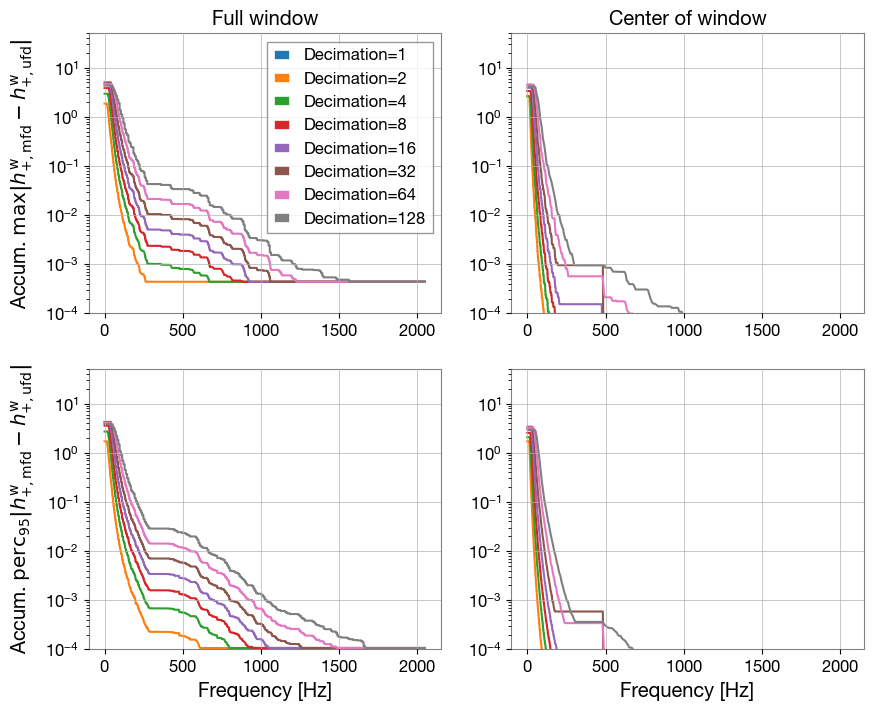

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
    
for decimation_factor in decimation_factors:
    # Construct convolution kernel
    kernel = torch.ones((1, 1, decimation_factor), dtype=torch.float64) / decimation_factor
    conv = lambda d: torch.nn.functional.conv1d(
        torch.tensor(d, dtype=torch.float64)[:, None, :], 
        kernel, 
        padding=0,
        stride=decimation_factor,
    ).squeeze()
    data_decimated = np.array(conv(data))

    # Compares the decimated value to all values within the decimation window
    # (most conservative estimate for difference between original and decimated data)
    d_ref = data
    f_ref = freq
    d_new = np.repeat(data_decimated, decimation_factor, axis=-1)
    n_pad = d_ref.shape[1] - d_new.shape[1]
    d_new = np.pad(d_new, ((0, 0), (0,n_pad)), 'constant', constant_values=0)
    diff = np.abs(d_ref - d_new)
    diff_max = np.max(diff, axis=0)
    diff_max = np.maximum.accumulate(diff_max[..., ::-1], axis=-1)[..., ::-1]
    diff_perc = np.percentile(diff, 99, axis=0)
    diff_perc = np.maximum.accumulate(diff_perc[..., ::-1], axis=-1)[..., ::-1]
    # Plot
    axs[0,0].plot(f_ref, diff_max, label=f"Decimation={decimation_factor}")
    axs[1,0].plot(f_ref, diff_perc, label=f"Decimation={decimation_factor}")
    
    # Compares the decimated value only to the waveform value at the frequency value in the middle of each band
    f_ref = conv(freq[None, :])
    inds_ref = (f_ref/ ufd_twice_res.delta_f).type(torch.int32)
    d_ref = data_2x[:, inds_ref]
    d_new = np.array(data_decimated)
    diff = np.abs(d_ref - d_new)
    diff_max = np.max(diff, axis=0)
    diff_max = np.maximum.accumulate(diff_max[..., ::-1], axis=-1)[..., ::-1]
    diff_perc = np.percentile(diff, 95, axis=0)
    diff_perc = np.maximum.accumulate(diff_perc[..., ::-1], axis=-1)[..., ::-1]
    # Plot
    axs[0,1].plot(f_ref, diff_max, label=f"Decimation={decimation_factor}")
    axs[1,1].plot(f_ref, diff_perc, label=f"Decimation={decimation_factor}")
    
axs[0,0].set_title("Full window")
axs[0,1].set_title("Center of window")
axs[0,0].set_ylabel(r"Accum. $\max \left|h^\mathrm{w}_\mathrm{+,mfd} - h^\mathrm{w}_\mathrm{+,ufd}\right|$")
axs[1,0].set_ylabel(r"Accum. $\mathrm{perc}_{95} \left|h^\mathrm{w}_\mathrm{+,mfd} - h^\mathrm{w}_\mathrm{+,ufd}\right|$")
axs[1,0].set_xlabel("Frequency [Hz]")
axs[1,1].set_xlabel("Frequency [Hz]")
axs[0,0].legend()
for ax in axs.flatten():
    ax.set_yscale('log')
    ax.set_ylim(1.e-4, 50)

We can observe that calculating the difference between the multibanded waveform and the original waveform over the full window is more conservative in the estimate than comparing at the center of the decimation window.

Using the full window with the max as a metric seems too strict since e.g. a threshold of $10^{-4}$ would not allow a decimation factor of 128 to be used.

Comparing max to 95th percentile, the maximum is less smooth.

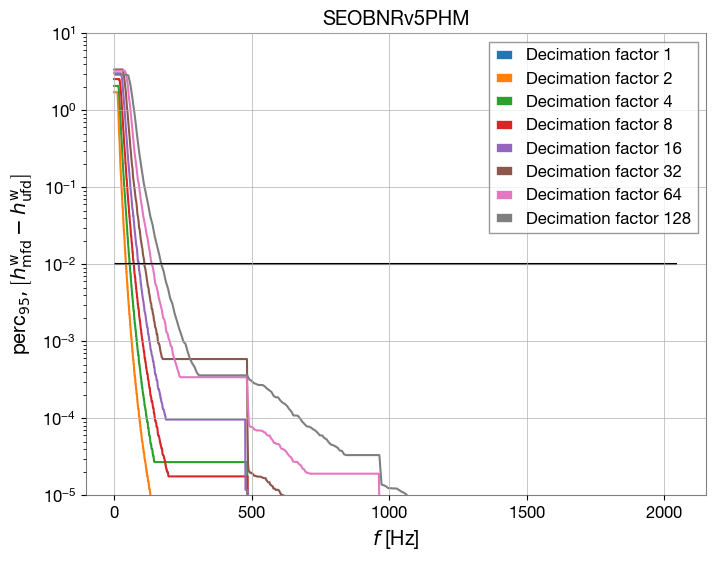

In [13]:
def compute_wf_difference_per_decimation_factor(
    decimation_factors: list, 
    waveforms: np.ndarray, 
    ufd: UniformFrequencyDomain, 
    waveforms_2x: np.ndarray,
    difference_over_full_window: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    waveformes have to be whitened
    """
    data = waveforms.real
    data_2x = waveforms_2x.real
    freq = ufd.sample_frequencies
    assert freq.shape[0] == data.shape[-1]

    freqs_per_decimation_factor = []
    diffs_per_decimation_factor = []
    for decimation_factor in decimation_factors:
        # Construct convolution kernel
        kernel = torch.ones((1, 1, decimation_factor), dtype=torch.float64) / decimation_factor
        conv = lambda d: torch.nn.functional.conv1d(
            torch.tensor(d, dtype=torch.float64)[:, None, :], 
            kernel, 
            padding=0,
            stride=decimation_factor,
        ).squeeze()
        # Apply conv to data
        data_decimated = conv(data).numpy()
    
        if difference_over_full_window:
            # Compare the decimated value to all values within the decimation window
            # (most conservative estimate for difference between original and decimated data)
            f_ref = freq
            data_ref = data
            data_decimated = np.repeat(data_decimated, decimation_factor, axis=-1)
            n_pad = data_ref.shape[1] - data_decimated.shape[1]
            data_decimated = np.pad(data_decimated, ((0, 0), (0, n_pad)), 'constant', constant_values=0)
        else:
            # Compare the decimated value only to the waveform value at the frequency value in the middle of each band
            f_ref = conv(freq[None, :])
            inds_ref = (f_ref / (ufd.delta_f / 2)).type(torch.int32)
            data_ref = data_2x[:, inds_ref]
        
        diff = np.abs(data_ref - data_decimated)
        diff_perc = np.percentile(diff, 95, axis=0)
        diff_perc = np.maximum.accumulate(diff_perc[..., ::-1], axis=-1)[..., ::-1]
        diffs_per_decimation_factor.append(diff_perc)
        freqs_per_decimation_factor.append(f_ref.numpy())

    return diffs_per_decimation_factor, freqs_per_decimation_factor


decimation_factors = 2 ** np.arange(8)
ufd = build_domain(uniform_frequency_domain_settings)
ufd_2x = build_domain({**ufd.domain_dict, **{"delta_f": ufd.delta_f / 2}})

# Whiten
d = polarizations["h_plus"] / asd / ufd.noise_std
d_2x = polarizations_twice_res["h_plus"] / asd_twice_res / ufd.noise_std # not ufd_2x!

diffs, freqs = compute_wf_difference_per_decimation_factor(decimation_factors, d, ufd, d_2x)

####### Plotting #######
fig = plt.figure()
plt.title(wfg_settings["approximant"])
fig.set_size_inches(8,6)

for i in range(len(decimation_factors)):
    plt.plot(freqs[i], diffs[i], label=f"Decimation factor {decimation_factors[i]}")
plt.yscale("log")
plt.ylim(1e-5, 1e1)
plt.legend()
plt.xlabel("$f$ [Hz]")
plt.ylabel(r"perc$_{95},\left[h^\mathrm{w}_\mathrm{mfd} - h^\mathrm{w}_\mathrm{ufd}\right]$")

# Define arbitrary threshold
threshold = 1e-2
plt.hlines(threshold, xmin=0, xmax=np.max(np.array(f_ref)), color="black", label="threshold")

plt.show()

# Defining the bands

Based on the maximal deviation of the decimated waveform and the waveform in ufd, we want to obtain the nodes that define the bands.
For this purpose, we select a threshold value for the maximal deviation (i.e., a horizontal line in the plot above) which will tell us the allowed decimation factor at a specific frequency.

Steps:
1. Obtain the maximal decimation factor for each frequency value in the ufd allowed by the threshold. These values should be monotonically increasing.

In [14]:
def compute_max_decimation_factor(
    decimation_factors: list, 
    diffs_per_decimation_factor: list, 
    freqs_per_decimation_factor: list, 
    ufd: UniformFrequencyDomain,
    threshold: float,
):
    # Start from maximal decimation of 1 for full domain
    max_dec_factor = np.ones(len(ufd()))
    f = ufd()
    
    f_max_threshold = []
    # Loop over decimation factors
    for decimation_factor, f, diff in zip(decimation_factors, freqs_per_decimation_factor, diffs_per_decimation_factor):
        # Find frequency above which the difference is smaller than the threshold, i.e., use this decimation factor above f_max
        f_max = f[np.argmax(diff < threshold)]
        #print(decimation_factor, f_max)
        if f_max_threshold:
            assert f_max_threshold[-1] <= f_max
        f_max_threshold.append(f_max)
        # Set larger decimation factor above f_max
        max_dec_factor[int(f_max / ufd.delta_f):] = decimation_factor
    return max_dec_factor


max_dec_factor_array = compute_max_decimation_factor(decimation_factors, diffs, freqs, ufd, threshold)

Included decimation factors [  1.   2.   4.   8.  16.  32.  64. 128.]


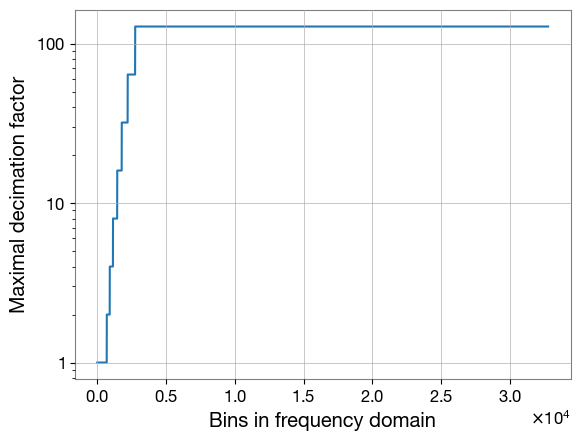

In [15]:
print("Included decimation factors", np.unique(max_dec_factor_array))
plt.plot(max_dec_factor_array)
plt.yscale('log')
plt.xlabel("Bins in frequency domain")
plt.ylabel("Maximal decimation factor");

2. Obtain the values for the location of the bands in frequency domain via `get_band_nodes_for_adaptive_decimation`.

In [16]:
delta_f_max = 2
# Get band nodes
initial_downsampling, band_nodes_indices = get_band_nodes_for_adaptive_decimation(
    max_dec_factor_array[ufd.min_idx:],
    max_dec_factor_global=int(delta_f_max / ufd.delta_f),
)
print(band_nodes_indices, len(ufd()[ufd.min_idx:]))
# Transform downsampling factor and band nodes from indices to frequencies
delta_f_initial = ufd.delta_f * initial_downsampling
nodes = ufd()[ufd.min_idx:][np.array(band_nodes_indices)]
print("Old shape of ufd:", ufd().shape)
mfd = MultibandedFrequencyDomain(nodes=nodes, delta_f_initial=delta_f_initial, base_domain=ufd)
print("New shape of ufd:", ufd().shape)

[0, 368, 586, 822, 1134, 1470, 32446] 32449
Old shape of ufd: (32769,)
New shape of ufd: (32766,)


In [17]:
# based on gw.domains.multibanded_frequency_domain.get_band_nodes_for_adaptive_decimation
from dingo.gw.domains.multibanded_frequency_domain import floor_to_power_of_2

def get_band_nodes_for_adaptive_decimation(
    max_dec_factor_array: np.ndarray, 
    max_dec_factor_global: int = np.inf,
):
    """
    Sets up adaptive multibanding for decimation. The 1D array max_dec_factor_array has
    the same length as the original, and contains the maximal acceptable decimation
    factors for each bin. max_dec_factor_global further specifies the maximum
    decimation factor.

    Parameters
    ----------
    max_dec_factor_array: np.ndarray
        Array with maximal decimation factor for each bin. Monotonically increasing.
    max_dec_factor_global: int = np.inf
        Global maximum for decimation factor.

    Returns
    -------
    initial_downsampling: int
        Downsampling factor of band 0.
    band_nodes: list[int]
        List with nodes for bands.
        Band j consists of indices [nodes[j]:nodes[j+1].
    """
    if len(max_dec_factor_array.shape) != 1:
        raise ValueError("max_dec_factor_array needs to be 1D array.")
    if not (max_dec_factor_array[1:] >= max_dec_factor_array[:-1]).all():
        raise ValueError("max_dec_factor_array needs to increase monotonically.")
    max_dec_factor_array = np.clip(max_dec_factor_array, None, max_dec_factor_global)
    N = len(max_dec_factor_array)
    dec_factor = int(max(1, floor_to_power_of_2(max_dec_factor_array[0])))
    band_nodes = [0]
    # Increment by decimation factor
    upper = dec_factor
    initial_downsampling = dec_factor
    while upper - 1 < N:
        #print('dec factor:', dec_factor, 'dec_factor*2:', 2*dec_factor, '<= max_dec_factor:', max_dec_factor_array[upper], 'upper:', upper, 'N:',N)
        if upper - 1 + dec_factor >= N:
            # Conclude while loop, append upper as last node
            band_nodes.append(upper)
        elif dec_factor * 2 <= max_dec_factor_array[upper]:
            # Conclude previous band
            band_nodes.append(upper)
            #print("New band at:", upper)
            # Enter new band
            dec_factor *= 2
        # Increment by decimation factor
        #print("increment by", dec_factor)
        upper += dec_factor

    return initial_downsampling, band_nodes

[0, 368, 586, 822, 1134, 1470, 32446] 32446


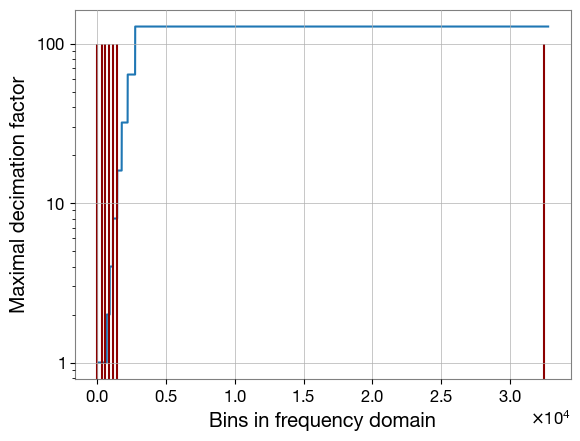

In [18]:
delta_f_max = 2 # limited due to maximal time-shift allowed because geocent time prior \in [-0.1, 0.1] ms
plt.plot(max_dec_factor_array)
# Get band nodes
initial_downsampling, band_nodes_indices = get_band_nodes_for_adaptive_decimation(
    max_dec_factor_array[ufd.min_idx:],
    max_dec_factor_global=int(delta_f_max / ufd.delta_f), # = delta_f_max * T
)
print(band_nodes_indices, len(ufd()[ufd.min_idx:]))
for node in band_nodes_indices:
    plt.vlines(node, 0, 100, color="darkred")
plt.yscale('log')
plt.xlabel("Bins in frequency domain")
plt.ylabel("Maximal decimation factor");

### How do these bands influence the signal?

In [19]:
ufd = build_domain(uniform_frequency_domain_settings)
# Transform downsampling factor and band nodes from indices to frequencies
delta_f_initial = ufd.delta_f * initial_downsampling
nodes = ufd()[ufd.min_idx:][np.array(band_nodes_indices)]
print("Old shape of ufd:", ufd().shape)
mfd = MultibandedFrequencyDomain(nodes=nodes, delta_f_initial=delta_f_initial, base_domain=ufd)
print("New shape of ufd:", ufd().shape, "mfd:", mfd().shape)

Old shape of ufd: (32769,)
New shape of ufd: (32766,) mfd: (1564,)


In [20]:
print("Compression factor:", len(ufd()[ufd.frequency_mask]) / len(mfd()))

Compression factor: 20.745524296675192


minimal chirp mass: 10.036918909406195


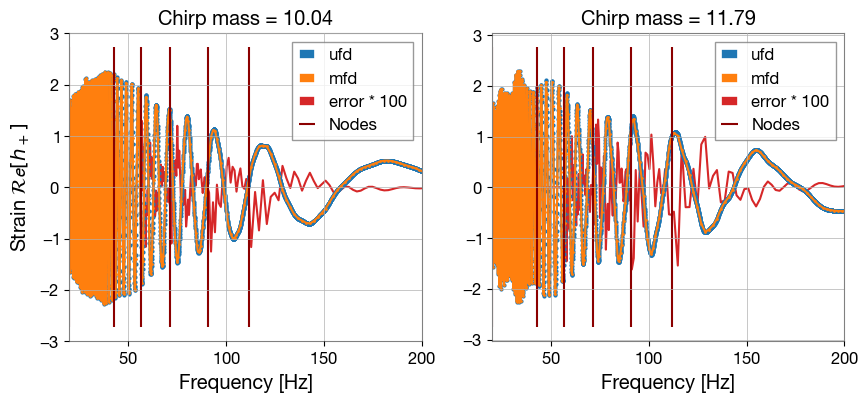

In [21]:
# Get waveform with minimal chirp mass
ind_minimal_chirp_mass = np.argmin(parameters["chirp_mass"])
print("minimal chirp mass:", parameters["chirp_mass"][ind_minimal_chirp_mass])

ind_random = 101
inds = [ind_minimal_chirp_mass, ind_random]

d = polarizations["h_plus"] / asd / ufd.noise_std
d = d.real

fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, ax in enumerate(axs):
    a = d[inds[i]][:len(mfd.base_domain)]
    b = mfd.decimate(a)
    b_interp = interp1d(ufd(), a)(mfd())
    
    ax.plot(ufd(), a, "-o", markersize=2, label="ufd")
    ax.plot(mfd(), b, "-o", markersize=1, label="mfd")
    ax.plot(mfd(), (b - b_interp) * 100, c="tab:red", label="error * 100", zorder=-5)

    a_val_max = np.abs(a).max()
    for f in mfd.nodes:
        ax.vlines(f, ymin=-a_val_max*1.2, ymax=a_val_max*1.2, color='darkred')
    ax.vlines(f, ymin=-a_val_max*1.2, ymax=a_val_max*1.2, color='darkred', label="Nodes")

    ax.legend()
    ax.set_xlim(20, np.max(ufd()))
    ax.set_xlim(20, 200)
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title(f"Chirp mass = {parameters['chirp_mass'][inds[i]]:.2f}")
    
axs[0].set_ylabel(r"Strain $\mathcal{Re}[h_+]$")

plt.show()

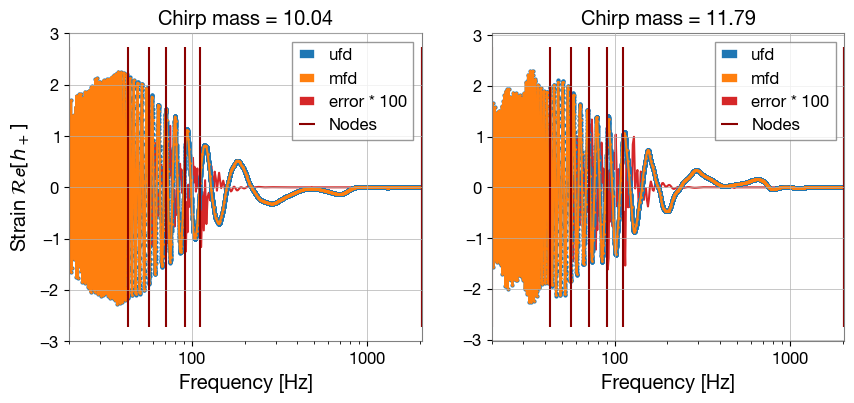

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, ax in enumerate(axs):
    a = d[inds[i]][:len(mfd.base_domain)]
    b = mfd.decimate(a)
    b_interp = interp1d(ufd(), a)(mfd())
    
    ax.plot(ufd(), a, "-o", markersize=2, label="ufd")
    ax.plot(mfd(), b, "-o", markersize=1, label="mfd")
    ax.plot(mfd(), (b - b_interp) * 100, c="tab:red", label="error * 100", zorder=-5)
    
    a_val_max = np.abs(a).max()
    for f in mfd.nodes:
        ax.vlines(f, ymin=-a_val_max*1.2, ymax=a_val_max*1.2, color='darkred')
    ax.vlines(f, ymin=-a_val_max*1.2, ymax=a_val_max*1.2, color='darkred', label="Nodes")

    ax.legend()
    ax.set_xlim(20, np.max(ufd()))
    #ax.set_xlim(20, 200)
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title(f"Chirp mass = {parameters['chirp_mass'][inds[i]]:.2f}")
    ax.set_xscale('log')
    
axs[0].set_ylabel(r"Strain $\mathcal{Re}[h_+]$")

plt.show()

Plot the same thing, but with mfd indices as x-axis

In [23]:
# Find mfd index of nodes in multibanded frequency domain
ind_bands = [np.argmin(np.abs(f - mfd())) for f in nodes]

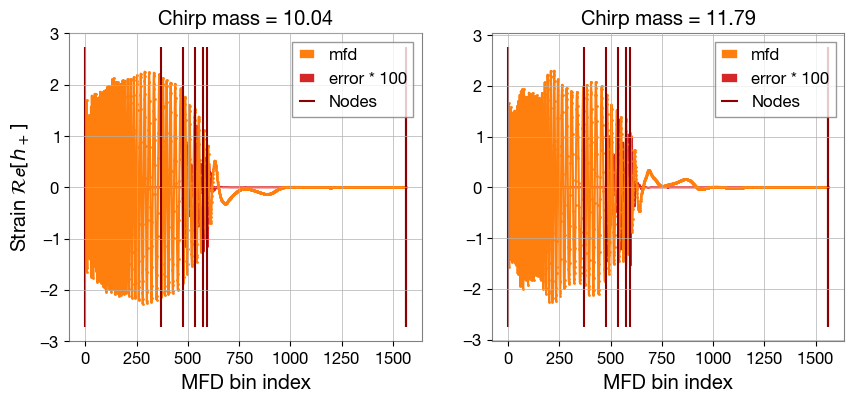

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, ax in enumerate(axs):
    a = d[inds[i]][:len(mfd.base_domain)]
    b = mfd.decimate(a)
    b_interp = interp1d(ufd(), a)(mfd())
    
    ax.plot(b, "-o", c="tab:orange", markersize=1, label="mfd")
    ax.plot((b - b_interp) * 100, c="tab:red", label="error * 100", zorder=-5)
    
    a_val_max = np.abs(a).max()
    for ind in ind_bands:
        ax.vlines(ind, ymin=-a_val_max*1.2, ymax=a_val_max*1.2, color='darkred')
    ax.vlines(ind, ymin=-a_val_max*1.2, ymax=a_val_max*1.2, color='darkred', label="Nodes")

    ax.legend()
    ax.set_xlabel("MFD bin index")
    ax.set_title(f"Chirp mass = {parameters['chirp_mass'][inds[i]]:.2f}")
    ax.set_xlim()
    
axs[0].set_ylabel(r"Strain $\mathcal{Re}[h_+]$")

plt.show()

### Calculate mismatch for bands

In [25]:
# Generate waveform datasets
from dingo.gw.dataset.generate_dataset import generate_waveforms_parallel
from dingo.gw.gwutils import get_mismatch

In [26]:
wfg_ufd = NewInterfaceWaveformGenerator(domain=ufd, **wfg_settings)
wfg_mfd = NewInterfaceWaveformGenerator(domain=mfd, **wfg_settings)

polarizations_ufd = generate_waveforms_parallel(wfg_ufd, parameters)
polarizations_mfd = generate_waveforms_parallel(wfg_mfd, parameters)

Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.
Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.


/Users/akofler/Desktop/gravitational_waves/code_production/dingo/dingo/gw/waveform_generator/waveform_generator.py:1108: UserWarning: GWSignal waveform longer than domain's `frequency_array`(32769 vs 32766). Truncating gwsignal array.
  warnings.warn(


In [26]:
def calculate_mismatch(
        wf_ufd: np.array,
        wf_mfd: np.array, 
        mfd: MultibandedFrequencyDomain,
        asd_file: str,
        in_ufd: bool = False,
):
    mismatches = []
    for idx in range(num_samples):
        mism = []
        for k in wf_mfd.keys():
            # extract polarizations at idx
            v1 = wf_mfd[k][idx]
            v2 = wf_ufd[k][idx]
            if in_ufd:
                # For waveforms generated in the time domain, compute the mismatch in the UFD -> interpolate MFD waveform
                ufd = mfd.base_domain
                v1_interp = ufd.update_data(interp1d(mfd(), v1, fill_value="extrapolate")(ufd()))
                mismatch = get_mismatch(
                    v1_interp,
                    v2,
                    domain=ufd,
                    asd_file=asd_file,
                )
            else:
                # For waveforms generated in the frequency domain
                v2_decimated = mfd.decimate(v2)
                # compute mismatch
                mismatch = get_mismatch(
                    v1,
                    v2_decimated,
                    domain=mfd,
                    asd_file=asd_file,
                )
            mism.append(mismatch)
        mismatches.append(mism)
    return np.array(mismatches)

In [28]:
mismatches = calculate_mismatch(wf_ufd=polarizations_ufd, wf_mfd=polarizations_mfd, mfd=mfd, asd_file=asd_file, in_ufd=True)
np.max(mismatches)

0.00018762566706631567

In [29]:
np.median(mismatches)

1.2526920238953299e-05

### Mismatches for waveform models
When waveform models are benchmarked against numerical relativity simulations, minimal/maximal mismatch values are reported, e.g. Fig. 6 in arXiv:2004.06503 for IMRPhenomXPHM.
They report mismatches between approx. $10^{-4} - 10^{-1}$, but the average maximal mismatch is around $10^{-2}$.

This means that a mismatch of $10^{-3}$ should be acceptable.

### Summarize procedure in function

In [30]:
def compute_multibanding_nodes_via_local_difference(
    settings_wfd: dict, 
    asd_file_path: str, 
    max_diff_threshold: float, 
    delta_f_max_time_shift: float, 
    num_samples: int = 1000, 
    num_processes_wfd_generation: int = 1
):

    # Build domains
    ufd = build_domain(settings_wfd["domain"])
    ufd_2x = build_domain({**ufd.domain_dict, **{"delta_f": ufd.delta_f / 2}})
    
    # Build prior
    prior = build_prior_with_defaults(settings_wfd["intrinsic_prior"])

    # Generate waveforms in a domain with twice the resolution of ufd, such that we can later compare 
    # the decimated mfd waveforms to the high-resolution waveform as a reference.
    waveform_generator = NewInterfaceWaveformGenerator(domain=ufd_twice_res, **settings_wfd["waveform_generator"])
    parameters, polarizations_2x = generate_parameters_and_polarizations(
        waveform_generator, prior, num_samples, num_processes=num_processes_wfd_generation
    )
    # Down-sample polarization to match standard ufd resolution
    polarizations = {k: v[...,::2] for k, v in polarizations_2x.items()}
    assert polarizations["h_plus"][0].shape == ufd().shape

    # Load ASD
    psd = PowerSpectralDensity(asd_file=asd_file_path)
    asd_interp = interp1d(psd.frequency_array, psd.asd_array, bounds_error=False, fill_value=np.inf)
    asd_2x = asd_interp(ufd_2x.sample_frequencies)
    # Remove the bump
    asd_2x[np.where((ufd_2x() > 477) & (ufd_2x() < 483))[0]] = asd_2x[np.argmin(np.abs(ufd_2x() - 477))]
    # Down-sample ASD to match standard ufd resolution
    asd = asd_2x[::2]

    # Whiten data
    data = {k: v / asd / ufd.noise_std for k,v in polarizations.items()}
    data_2x = {k: v / asd_2x / ufd.noise_std for k,v in polarizations_2x.items()} # not ufd_2x!

    # Decimate data for different decimation factors and calculate difference 
    diffs, freqs = compute_wf_difference_per_decimation_factor(decimation_factors, data["h_cross"], ufd, data_2x["h_cross"])
    # Compute maximal decimation factor per ufd frequency bin
    max_dec_factor = compute_max_decimation_factor(decimation_factors, diffs, freqs, ufd, threshold=max_diff_threshold)

    # Get band nodes
    initial_downsampling, band_nodes_indices = get_band_nodes_for_adaptive_decimation(
        max_dec_factor[ufd.min_idx:],
        max_dec_factor_global=int(delta_f_max_time_shift / ufd.delta_f),
    )
    # Transform downsampling factor and band nodes from indices to frequencies
    delta_f_initial = ufd.delta_f * initial_downsampling
    mfd_nodes = ufd()[ufd.min_idx:][np.array(band_nodes_indices)]
    print("Nodes of multibanded frequency domain:", mfd_nodes)
    # Compute compression factor
    mfd = MultibandedFrequencyDomain(nodes=nodes, delta_f_initial=delta_f_initial, base_domain=ufd)
    print("Compression factor:", len(ufd()[ufd.frequency_mask]) / len(mfd()))

    # Compute mismatch between ufd and mfd
    print("Generating datasets for mismatch computation...")
    wfg_ufd = NewInterfaceWaveformGenerator(domain=ufd, **wfg_settings)
    wfg_mfd = NewInterfaceWaveformGenerator(domain=mfd, **wfg_settings)
    polarizations_ufd = generate_waveforms_parallel(wfg_ufd, parameters)
    polarizations_mfd = generate_waveforms_parallel(wfg_mfd, parameters)
    if wfg_settings["approximant"] in ["SEOBNRv5PHM"]:
        # Compute mismatch in base domain if waveform generated in UFD
        in_ufd = True
    else:
        in_ufd = False
    mismatches = calculate_mismatch(wf_ufd=polarizations_ufd, wf_mfd=polarizations_mfd, mfd=mfd, asd_file=asd_file, in_ufd=in_ufd)
    print("Mean mismatch:", np.mean(mismatches), "Median mismatch:", np.median(mismatches), "Max mismatch:", np.max(mismatches))
    
    return mfd_nodes, delta_f_initial

In [28]:
# Load waveform dataset settings
# Load settings file
settings_file = "settings_wfd.yaml"
try:
    with open(settings_file, "r") as file:
        settings_wfd = yaml.safe_load(file)
except FileNotFoundError:
    print(f"Settings file '{settings_file}' not found. Please ensure it exists in the directory.")
# Set window factor for ufd
settings_wfd["domain"]["window_factor"] = 4.

asd_file = "aLIGO_ZERO_DET_high_P_asd.txt"

In [29]:
nodes_mfd, delta_f_initial = compute_multibanding_nodes_via_local_difference(
    settings_wfd=settings_wfd, 
    asd_file_path=asd_file, 
    max_diff_threshold=1.e-2,
    delta_f_max_time_shift=2.,
)

Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.
Generating dataset of size 1000
Nodes of multibanded frequency domain: [  20.      41.875   54.875   69.375   86.875  107.875 2047.875]
Compression factor: 20.745524296675192
Generating datasets for mismatch computation...
Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.
Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.


/Users/akofler/Desktop/gravitational_waves/code_production/dingo/dingo/gw/waveform_generator/waveform_generator.py:1108: UserWarning: GWSignal waveform longer than domain's `frequency_array`(32769 vs 32766). Truncating gwsignal array.
  warnings.warn(


Mean mismatch: 1.958036273243208e-05 Median mismatch: 1.2760039694026393e-05 Max mismatch: 0.00013829246052543542


### Compute mismatch for IMRPhenomXPHM with EOB nodes

In [31]:
from copy import deepcopy
wfg_settings_xphm = deepcopy(wfg_settings)
wfg_settings_xphm['approximant'] = 'IMRPhenomXPHM'
wfg_settings_xphm.pop('new_interface')
wfg_settings_xphm

{'approximant': 'IMRPhenomXPHM',
 'f_ref': 20.0,
 'f_start': 13.33,
 'spin_conversion_phase': 0.0}

In [32]:
# Compute mismatch between ufd and mfd
print("Generating datasets for mismatch computation...")
wfg_ufd_xphm = WaveformGenerator(domain=ufd, **wfg_settings_xphm)
wfg_mfd_xphm = WaveformGenerator(domain=mfd, **wfg_settings_xphm)
polarizations_ufd_xphm = generate_waveforms_parallel(wfg_ufd_xphm, parameters)
polarizations_mfd_xphm = generate_waveforms_parallel(wfg_mfd_xphm, parameters)
mismatches = calculate_mismatch(wf_ufd=polarizations_ufd_xphm, wf_mfd=polarizations_mfd_xphm, mfd=mfd, asd_file=asd_file, in_ufd=False)
print("Mean mismatch:", np.mean(mismatches), "Median mismatch:", np.median(mismatches), "Max mismatch:", np.max(mismatches))

Generating datasets for mismatch computation...
Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.
Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.


/Users/akofler/Desktop/gravitational_waves/code_production/dingo/dingo/gw/waveform_generator/waveform_generator.py:630: UserWarning: LALsimulation waveform longer than domain's `frequency_array`(32769 vs 32766). Truncating lalsim array.
  warnings.warn(


Mean mismatch: 8.357736927297466e-07 Median mismatch: 5.241694076563164e-07 Max mismatch: 7.986992523356662e-06


In [35]:
print("Nodes", list(nodes_mfd))
print("delta_f_initial", delta_f_initial)

Nodes [20.0, 41.875, 54.875, 69.375, 86.875, 107.875, 2047.875]
delta_f_initial 0.0625


In [39]:
# Update settings
new_settings_eob = {
    "type": 'MultibandedFrequencyDomain',
    "nodes": list(nodes_mfd),
    "delta_f_initial": delta_f_initial,
    "base_domain": wfg_settings,
}
new_settings_xphm = {
    "type": 'MultibandedFrequencyDomain',
    "nodes": list(nodes_mfd),
    "delta_f_initial": delta_f_initial,
    "base_domain": wfg_settings_xphm,
}
print("New settings for EOB:\n", new_settings_eob)
print("New settings for XPHM:\n", new_settings_xphm)

New settings for EOB:
 {'type': 'MultibandedFrequencyDomain', 'nodes': [20.0, 41.875, 54.875, 69.375, 86.875, 107.875, 2047.875], 'delta_f_initial': 0.0625, 'base_domain': {'approximant': 'IMRPhenomXPHM', 'f_ref': 20.0, 'f_start': 13.33, 'spin_conversion_phase': 0.0}}
New settings for XPHM:
 {'type': 'MultibandedFrequencyDomain', 'nodes': [20.0, 41.875, 54.875, 69.375, 86.875, 107.875, 2047.875], 'delta_f_initial': 0.0625, 'base_domain': {'approximant': 'IMRPhenomXPHM', 'f_ref': 20.0, 'f_start': 13.33, 'spin_conversion_phase': 0.0}}
